In [10]:
# Generic imports
import sys; sys.path.insert(0, '../')
import copy
import os
import scipy.interpolate
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import \
matrix, linspace, meshgrid, sin, cos, array, sqrt, pi, diff, mean, median, std, arcsin, zeros, random, \
size, reshape, shape, vstack, eye, diag, nan_to_num, ones, loadtxt, savetxt, append, squeeze
from scipy.special import gamma
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image, ImageFont, ImageDraw
import time
from matplotlib import animation
from scipy.interpolate import griddata
from scipy.special import gamma

# Application-specific imports
import facetbrightnessstuff9 as fbs
import imagestuff as ims
import gradstuff as gds
import stlstuff as sls #Connor commented this out because I had an error "No module named 'stlstuff'

# Graphics imports and parameters
#%matplotlib inline
%matplotlib notebook
fontsize = 25
linewidth = 2
matplotlib.rcParams.update({'font.size': fontsize})

In [ ]:
# Set defaults for the analysis
rmaxforhist = .19 # This is the default
drforhist = .005 # default
accumlist = [] # This will get filled in as the entire set of segments unless overridden below

#case = 'case1.6'; rmaxforhist = .19; drforhist = .005; eta_visual = .70
#case = 'case1.11'; rmaxforhist = .19; drforhist = .005; eta_visual = .80
#case = 'case1.14'; rmaxforhist = .19; drforhist = .005; eta_visual = .80
#case = 'case1.17'; rmaxforhist = .19; drforhist = .005; eta_visual = .80
#case = 'case1.21'; rmaxforhist = .19; drforhist = .005; eta_visual = .70
#case = 'case1.25'; rmaxforhist = .19; drforhist = .005; eta_visual = .75
#case = 'case1.7'; rmaxforhist = .19; drforhist = .005; eta_visual = .95
#case = 'case1.8'; rmaxforhist = .19; drforhist = .005; eta_visual = .80
#case = 'case1.12'; rmaxforhist = .19; drforhist = .005; eta_visual = .80
#case = 'case1.15'; rmaxforhist = .19; drforhist = .005; eta_visual = .80
#case = 'case1.19'; rmaxforhist = .19; drforhist = .005; eta_visual = .90
#case = 'case1.24'; rmaxforhist = .19; drforhist = .005; eta_visual = .85
#case = 'case1.3'; rmaxforhist = .19; drforhist = .005
#case = 'case1.16'; rmaxforhist = .19; drforhist = .005
#case = 'case1.18'; rmaxforhist = .19; drforhist = .005
#case = 'case1.26'; rmaxforhist = .19; drforhist = .005; eta_visual = .95

In [11]:
# This is the "ice4" structure (choose one block below)

# case = 'crystals/2016-08-09_ice1/case1.26'
# rmaxforhist = .19
# drforhist = .005
# eta_visual = .95

case = 'crystals/2016-06-30_ice4/case4.1'
accumlist = [0,1,2,8,9,10]
rmaxforhist=0.12
drforhist = .005
eta_visual = .95

In [12]:
# Get the retrieved surface
print("loading", case)
npzfile = np.load(case+'/retrieved.npz')
surfaceroot = np.array_str(npzfile['surfaceroot'])
imageroot = np.array_str(npzfile['imageroot'])
dx,dy,cA,cB,cC,cD,Filename = ims.getc2(surfaceroot, '/SEMimages', imageroot)
print("dx and dy", dx, dy)
nx1list = npzfile['nx1list']
nx2list = npzfile['nx2list']
ny1list = npzfile['ny1list']
ny2list = npzfile['ny2list']
pA = npzfile['pA']
pB = npzfile['pB']
pC = npzfile['pC']
pD = npzfile['pD']
sA = npzfile['sA']
sB = npzfile['sB']
sC = npzfile['sC']
sD = npzfile['sD']
nxi = npzfile['nxi']
nyi = npzfile['nyi']
dnx = npzfile['dnx']
dny = npzfile['dny']
solution = npzfile['solution']
nsegments = len(nx1list)
if len(accumlist)==0:
    accumlist = [i for i in range(nsegments)]
    
print('Completed',case) #Prints loading but I wanted to know when it was done.

('dx and dy', 0.9586353000000001, 0.9586353000000001)
('Completed', 'crystals/2016-06-30_ice4/case4.1')


In [13]:
Iwantroughness = True
Iwanttosave = False
Iwantlog = True
IwantURT = True
Iwantstl = True

<IPython.core.display.Javascript object>


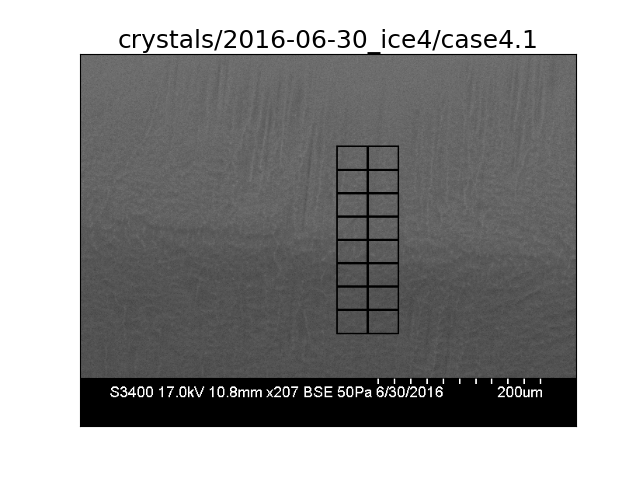

In [14]:
# Graph the segments
im = Image.open(Filename)
ny_im,nx_im = np.shape(im)
draw = ImageDraw.Draw(im)
fig, ax = plt.subplots()
for i in range(nsegments):
    nx1 = nx1list[i]
    nx2 = nx2list[i]
    ny1 = ny1list[i]
    ny2 = ny2list[i]
    ims.myrectangle(draw,(nx1,ny1),(nx2,ny2),2)
ax.set_title(surfaceroot,fontsize=fontsize*0.9)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
Iwantmicrons = False
if Iwantmicrons:
    ax.imshow(im,cmap = 'Greys_r', vmin = 0,vmax = 255, extent=[0,nx_im*dx,0,ny_im*dy])
    ax.set_xlabel(r'$x \ (\mu m)$',fontsize=fontsize*1.1)
    ax.set_ylabel(r'$y \ (\mu m)$',fontsize=fontsize*1.1)
else:
    ax.imshow(im,cmap = 'Greys_r', vmin = 0,vmax = 255)


80
240


<IPython.core.display.Javascript object>


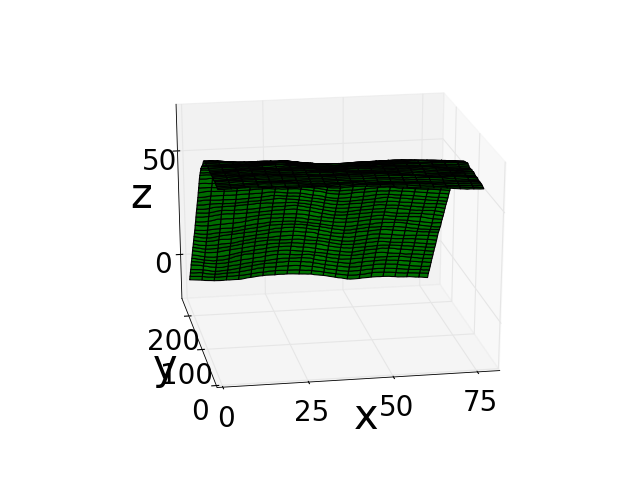

In [15]:
# Show the reconstructed surface
nx1tot = min(nx1list)
nx2tot = max(nx2list)
ny1tot = min(ny1list)
ny2tot = max(ny2list)
nxtot = nx2tot-nx1tot; print (nxtot)
nytot = ny2tot-ny1tot; print (nytot)
ymaxtot = (nytot-1)*dy; xmaxtot = (nxtot-1)*dx

surf_ytot = linspace(0,ymaxtot,nytot); #print surf_ytot[1]-surf_ytot[0]; 
surf_xtot = linspace(0,xmaxtot,nxtot); #print surf_xtot[1]-surf_xtot[0]; 
surf_xgridtot, surf_ygridtot = meshgrid(surf_xtot,surf_ytot)
surf_ygridtot_flipped = np.flipud(surf_ygridtot)
settemp = solution[ny1tot:ny2tot,nx1tot:nx2tot]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(surf_xgridtot, surf_ygridtot_flipped, settemp, rstride=4,cstride=4, color='g')
ax.view_init(azim=-100,elev=22)
ax.set_xlabel('x',fontsize=fontsize*1.5)
ax.set_ylabel('y',fontsize=fontsize*1.5)
ax.set_zlabel('z',fontsize=fontsize*1.5)

# Tailor these lines for each case
ax.set_xticks([i for i in range(0,100,25)])
ax.set_yticks([i for i in range(0,250,100)])
ax.set_zticks([i for i in range(0,100,50)])

In [16]:
if Iwantstl:
    sls.numpy2stl(settemp, case+'/retrieved.stl', scale=dx, solid=False)

Creating top mesh...


In [17]:
import itertools
def polyfit2d(x, y, z, order=3, linear=False):
    """Two-dimensional polynomial fit. Based uppon code provided by 
    Joe Kington.

    References:
        http://stackoverflow.com/questions/7997152/
            python-3d-polynomial-surface-fit-order-dependent/7997925#7997925

    """
    ncols = (order + 1)**2
    G = np.zeros((x.size, ncols))
    ij = itertools.product(range(order+1), range(order+1))
    for k, (i,j) in enumerate(ij):
        G[:,k] = x**i * y**j
        if linear & (i != 0.) & (j != 0.):
            G[:, k] = 0
    m, _, _, _ = np.linalg.lstsq(G, z)
    return m

def polyval2d(x, y, m):
    """Values to two-dimensional polynomial fit. Based upon code 
        provided by Joe Kington.
    """
    order = int(np.sqrt(len(m))) - 1
    ij = itertools.product(range(order+1), range(order+1))
    z = np.zeros_like(x)
    for a, (i,j) in zip(m, ij):
        z += a * x**i * y**j
    return z


def flatten(surf_xseggrid, surf_yseggrid, surf_zseggrid, Rotx):
    # Rotates every point in the dataset
    thisshape = np.shape(surf_xseggrid)
    surf_xseggridp = np.zeros(thisshape)
    surf_yseggridp = np.zeros(thisshape)
    surf_zseggridp = np.zeros(thisshape)
    for ix in range (thisshape[1]):
        for iy in range (thisshape[0]):
            vec = np.matrix([surf_xseggrid[iy,ix],surf_yseggrid[iy,ix],surf_zseggrid[iy,ix]]).T
            vecp = Rotx*vec
            surf_xseggridp[iy,ix] = vecp[0]
            surf_yseggridp[iy,ix] = vecp[1]
            surf_zseggridp[iy,ix] = vecp[2]
    return surf_xseggridp, surf_yseggridp, surf_zseggridp

def pWeibull(r, sigma, eta):
    ''' Weibull function to be fit. '''

    from numpy import exp

    mu = 1-r
    ret = 2*eta/sigma**2/mu**3 * \
        (((mu**(-2)-1)/sigma**2)**(eta-1)) * \
        exp(-((mu**(-2)-1)/sigma**2)**eta)
    return ret

In [18]:
# Now, to evaluate the roughness ... First step is to flatten each panel via rotation
# Here we explicitly flip the y-coordinate (to make it a right-handed system) so we don't have to invert on the fly

stride = 1

hbins_accum = []
meanrsub_accum = []
zsigma_accum = []
Z2_accum = []
Zsquared_accum = []
rsub_accum = []

meanrsublist = []
Zsigmalist = []
Z2list = []

if Iwantroughness:
    
    # Sets up an output folder
    directory = case
    if not os.path.exists(directory):
        os.makedirs(directory)


    for isegment in range(0,nsegments):
    #for isegment in range(15,16):

        # Extract this segment
        nx1=nx1list[isegment]; nx2=nx2list[isegment]; nxsegment = nx2-nx1+1
        ny1=ny1list[isegment]; ny2=ny2list[isegment]; nysegment = ny2-ny1+1
        surf_xseg = np.linspace(0,(nxsegment-1)*dx,nxsegment); 
        surf_yseg = np.linspace(0,(nysegment-1)*dy,nysegment); 
        surf_xseggrid, surf_yseggrid = meshgrid(surf_xseg,surf_yseg) # 1st index is y, 2nd is x
        surf_zseggrid = copy.copy(np.flipud(solution[ny1:ny2+1,nx1:nx2+1])) # This flips the y-coordinate

        # Fit a plane to the data and adjust data to start at the origin
        m = polyfit2d(\
                      surf_xseggrid.reshape(nysegment*nxsegment), \
                      surf_yseggrid.reshape(nysegment*nxsegment), \
                      surf_zseggrid.reshape(nysegment*nxsegment), \
                      linear=True,order=1)
        
        # Get the angles of the plane
        dzdy = m[1]; thetay = np.arctan(dzdy)*180/np.pi; #print 'y:', thetay

        # Get rotation matrix & flatten in one direction
        Roty = ims.myrotation_matrix([1,0,0], -thetay)
        surf_xseggridp, surf_yseggridp, surf_zseggridp = \
            flatten(surf_xseggrid, surf_yseggrid, surf_zseggrid, Roty)

        # Fit a plane to the data and adjust data to start at the origin
        mp = polyfit2d(\
                      surf_xseggridp.reshape(nysegment*nxsegment), \
                      surf_yseggridp.reshape(nysegment*nxsegment), \
                      surf_zseggridp.reshape(nysegment*nxsegment), \
                      linear=True,order=1)
        
        # Get the angle of the plane in another direction
        dzdx = mp[2]; thetaxp = np.arctan(dzdx)*180/np.pi; #print 'x:', thetaxp

        # Get rotation matrix & flatten in another direction
        Rotxp = ims.myrotation_matrix([0,1,0], thetaxp)
        surf_xseggridpp, surf_yseggridpp, surf_zseggridpp = \
            flatten(surf_xseggridp, surf_yseggridp, surf_zseggridp, Rotxp)

            
        # Trying out the polyval2d
        surf_zseggrid_theory_long = polyval2d(\
                      surf_xseggrid.reshape(nysegment*nxsegment), \
                      surf_yseggrid.reshape(nysegment*nxsegment), \
                      m)
        surf_zseggrid_theory = surf_zseggrid_theory_long.reshape(nysegment,nxsegment)
        #surf_zseggrid_theory -= z0
        surf_xseggridp_theory, surf_yseggridp_theory, surf_zseggridp_theory = \
            flatten(surf_xseggrid, surf_yseggrid, surf_zseggrid_theory, Roty)
        surf_xseggridpp_theory, surf_yseggridpp_theory, surf_zseggridpp_theory = \
            flatten(surf_xseggridp_theory, surf_yseggridp_theory, surf_zseggridp_theory, Rotxp)

        # Now rotate
        deltay = surf_yseggridpp_theory[0,-1]-surf_yseggridpp_theory[0,0]
        deltax = surf_xseggridpp_theory[0,-1]-surf_xseggridpp_theory[0,0]
        thetazpp = -np.arctan(deltay/deltax)*180/np.pi;
        Rotzpp = ims.myrotation_matrix([0,0,1], thetazpp)
        surf_xseggridppp, surf_yseggridppp, surf_zseggridppp = \
            flatten(surf_xseggridpp, surf_yseggridpp, surf_zseggridpp, Rotzpp)
        surf_xseggridppp_theory, surf_yseggridppp_theory, surf_zseggridppp_theory = \
            flatten(surf_xseggridpp_theory, surf_yseggridpp_theory, surf_zseggridpp_theory, Rotzpp)

        # Now we have to extract an orthogonal subset
        dxsub = dysub = dx
        xsubstart = np.max(surf_xseggridppp_theory[[0,-1],0])+dxsub*2
        xsubstop = np.min(surf_xseggridppp_theory[[0,-1],-1])-dxsub*2
        ysubstart = np.max(surf_yseggridppp_theory[0,[0,-1]])+dysub*2
        ysubstop = np.min(surf_yseggridppp_theory[-1,[0,-1]])-dysub*2
        xsub = np.arange(xsubstart,xsubstop,dxsub)
        ysub = np.arange(ysubstart,ysubstop,dysub)
        sub_xseggrid, sub_yseggrid = meshgrid(xsub,ysub) # 1st index is y, 2nd is x
        nsuby, nsubx = np.shape(sub_xseggrid)
        surf_xseggridppp_theory_long = np.reshape(surf_xseggridppp_theory,nysegment*nxsegment)
        surf_yseggridppp_theory_long = np.reshape(surf_yseggridppp_theory,nysegment*nxsegment)
        points = np.vstack((surf_xseggridppp_theory_long,surf_yseggridppp_theory_long)).T # rows are x,y pairs
        values = np.reshape(surf_zseggridppp,nysegment*nxsegment)
        sub_zseggrid_long = griddata(points, values, (sub_xseggrid, sub_yseggrid), method='cubic')
        sub_zseggrid = np.reshape(sub_zseggrid_long,(nsuby, nsubx))
        
        # Now we get the roughness
        dzsub_dx = diff(sub_zseggrid,axis=1)/diff(sub_xseggrid,axis=1)
        dzsub_dy = diff(sub_zseggrid,axis=0)/diff(sub_yseggrid,axis=0)
        Zsquared = dzsub_dx[1:,:]**2+dzsub_dy[:,1:]**2
        rsub = 1.0 - 1/np.sqrt(1+Zsquared)
        mu = 1-rsub
        phi = np.arccos(mu)
        Zplus = Zsquared**.5
        Z = np.hstack((Zplus,-Zplus)) # Need +/- to generate a two-sided distribution
        thismeanrsub = np.round(np.mean(rsub)*1000)/1000; meanrsublist.append(thismeanrsub)
        thissigma = np.round(np.std(Z)*100)/100; Zsigmalist.append(thissigma)
        thismeanZ2 = np.mean(Zsquared); Z2list.append(thismeanZ2)
        
        # Plotting surfaces
        title1 = 'panel_' +list(map(str,[isegment+1]))[0]#"TypeError: 'map' object is not subscriptable" stackoverflow said added the list() so the map is indexable
        
        # Numerical distribution functions
        rsub_long = np.reshape(rsub,np.size(rsub))
        hist = np.histogram(rsub_long,bins=np.arange(0,rmaxforhist,drforhist))
        rbins = hist[1][0:-1]
        hbins = hist[0] 
        norm = -np.trapz(rbins,hbins)
        hbins = hbins/norm
        rwidth = np.diff(rbins)[0]
        
        # Defining the analytical distribution function bins
        rbinsW = (rbins+rwidth/2.0)        
                
        # Accumulate the binned data
        if isegment in accumlist:
            hbins_accum.append(hbins)
            meanrsub_accum.append(thismeanrsub)
            zsigma_accum.append(thissigma)
            Z2_accum.append(thismeanZ2)
            
            Zsquared_long = np.reshape(Zsquared,np.size(Zsquared))
            Zsquared_accum = np.append(Zsquared_accum,Zsquared_long)
            
            rsub_long = np.reshape(rsub,np.size(rsub))
            rsub_accum = np.append(rsub_accum,rsub_long)
            
            print('Accumulating ...', np.shape(Zsquared), np.shape(Zsquared_long), np.shape(Zsquared_accum))
            

            
for isegment in range(len(meanrsublist)):
    print('segment, #pts, <r>, sigma =', \
        isegment, np.size(rsub), meanrsublist[isegment], Zsigmalist[isegment])


('Accumulating ...', (31, 35), (1085,), (1085,))
('Accumulating ...', (31, 35), (1085,), (2170,))
('Accumulating ...', (30, 35), (1050,), (3220,))
('Accumulating ...', (31, 34), (1054,), (4274,))
('Accumulating ...', (30, 34), (1020,), (5294,))
('Accumulating ...', (30, 34), (1020,), (6314,))
('segment, #pts, <r>, sigma =', 0, 936, 0.012999999999999999, 0.16)
('segment, #pts, <r>, sigma =', 1, 936, 0.010999999999999999, 0.14999999999999999)
('segment, #pts, <r>, sigma =', 2, 936, 0.010999999999999999, 0.14999999999999999)
('segment, #pts, <r>, sigma =', 3, 936, 0.0080000000000000002, 0.13)
('segment, #pts, <r>, sigma =', 4, 936, 0.0089999999999999993, 0.13)
('segment, #pts, <r>, sigma =', 5, 936, 0.0080000000000000002, 0.13)
('segment, #pts, <r>, sigma =', 6, 936, 0.0060000000000000001, 0.11)
('segment, #pts, <r>, sigma =', 7, 936, 0.0060000000000000001, 0.11)
('segment, #pts, <r>, sigma =', 8, 936, 0.0089999999999999993, 0.14000000000000001)
('segment, #pts, <r>, sigma =', 9, 936, 0.0

<IPython.core.display.Javascript object>


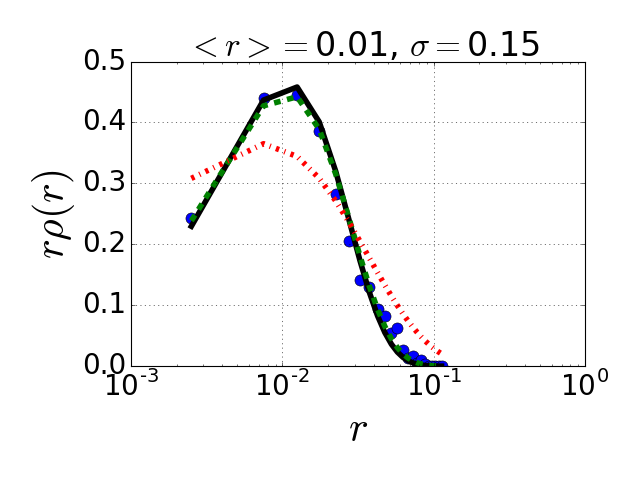

('<Z2> = ', 0.021618635062578065)
('<r> = ', 0.010447400026920824)
('sigma = ', 0.15362623092420641)
('Using visual eta, predicted sigma_W = ', 0.14534173701896391)
('Using eta = ', 0.95)


In [19]:
# This graphs observed and Weibull results

if Iwantlog:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    hbins_total = np.sum((hbins_accum),axis=0)/len(accumlist)
    Zsigma_total = np.sum(zsigma_accum)/len(accumlist)
    meanrsub_total = np.sum(meanrsub_accum)/len(accumlist); meanrsub_total=np.round(meanrsub_total*1000)/1000
    
    MTTF = np.sum(Z2_accum)/len(accumlist)
    rMTTF = np.sqrt(MTTF)
    rMTTF_legend = np.round(np.mean(rMTTF)*100)/100
    
    meanZ2 = np.mean(Zsquared_accum); #print '<Z2> = ', meanZ2 
    sigma2 = np.std(Zsquared_accum); #print 'std(Z2) = ', sigma2
    sigma_legend = np.round(np.mean(sigma2**.5)*100)/100
    meanr = np.mean(rsub_accum); #print '<r>, 2*<r> = ', meanr, 2*meanr
    Rval = meanZ2/sigma2
    alpha = (np.pi**2-9.0)/6
    eta_predicted = Rval + alpha*(1-Rval)**2
    sigmaW2_predicted = meanZ2/gamma(1.0/eta_predicted+1)
    print('<Z2> = ', meanZ2)
    print('<r> = ', meanr)
    print('sigma = ', sigma2**.5)
    #print 'Predicted eta = ', eta_predicted
    #print 'Predicted sigma_W = ', sigmaW2_predicted**.5

    sigmaW2_visual = meanZ2/gamma(1.0/eta_visual+1)
    print('Using visual eta, predicted sigma_W = ', sigmaW2_visual**.5)
    print('Using eta = ', eta_visual)
    

    eta = 1; sigma2 = MTTF/gamma(1/eta+1); sigma = sigma2**.5
    hbinsW1 = pWeibull(rbinsW, sigma, eta); norm = -np.trapz(rbins,hbinsW1); hbinsW1 = hbinsW1/norm        
    
    eta = eta_visual; sigma2 = MTTF/gamma(1/eta+1); sigma = sigma2**.5
    hbinsW3 = pWeibull(rbinsW, sigma, eta); norm = -np.trapz(rbins,hbinsW3); hbinsW3 = hbinsW3/norm

    eta = 0.6; sigma2 = MTTF/gamma(1/eta+1); sigma = sigma2**.5 
    hbinsW5 = pWeibull(rbinsW, sigma, eta); norm = -np.trapz(rbins,hbinsW5); hbinsW5 = hbinsW5/norm

    ax.semilogx(rbinsW,hbins_total*rbinsW,'o',markersize=10)
    ax.semilogx(rbinsW,hbinsW1*rbinsW,'k-',linewidth=5)
    ax.semilogx(rbinsW,hbinsW3*rbinsW,'g--',linewidth=5)
    ax.semilogx(rbinsW,hbinsW5*rbinsW,'r-.',linewidth=5)

    ax.set_xlabel(r'$r$',fontsize=fontsize*1.5)
    ax.set_ylabel(r'$r\rho(r)$',fontsize=fontsize*1.5)
    #ax.legend(['obs',r'$\eta=1$',r'$\eta=0.8$',r'$\eta=0.6$',r'URT'],loc='upper right',numpoints=1)
    ax.grid('on')
    title2 = r' $<r>=$'+list(map(str,[meanrsub_total]))[0]+r', $\sigma=$'+list(map(str,[sigma_legend]))[0] #"TypeError: 'map' object is not subscriptable" Stackoverflow said add list() to make indexable
    ax.set_title(title2)
    plt.tight_layout()
    #print 'total r, sigma:', meanrsub_total, Zsigma_total
    if Iwanttosave:
        fig.savefig(case+'/Roughness.jpg')
